In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image
from collections import defaultdict
import pyamg


In [11]:
def stats(A):
    return A.dtype, A.shape, np.min(A), np.median(A), np.max(A)

def get_maximum(A):
    init = A[0]
    for a in A[1:]:
        init = np.maximum(a, init)
    return init


img stats: (dtype('float64'), (640, 640), 0.0, 192.0, 192.0)


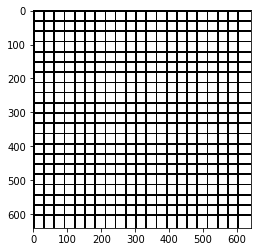

In [16]:
def draw_line(img, l, r, hor):
    if hor:
        img[l:r,:] = 0
    else:
        img[:,l:r] = 0

size = 640
img = np.ones((size, size))
img[img == 1] = 192
n = 30
for i in range(size // n):  
    l = 0 + n * i
    r = 5 + n * i
    draw_line(img, l, r, True)
    draw_line(img, l, r, False)
        
print(f"img stats: {stats(img)}")
plt.imshow(img, cmap='gray')

In [7]:
def gen_circle(img , center, r):
    color = (255, 255, 255) 
    thickness = -1
    return cv2.circle(img, center, r, color, thickness) 

r = 80
centers = [(150,150), (450, 150) , (450, 450), (150, 450)]
circles = []
for center in centers:
    circles.append(gen_circle(np.copy(img) , center, r))

Text(0.5, 1.0, 'gucci')

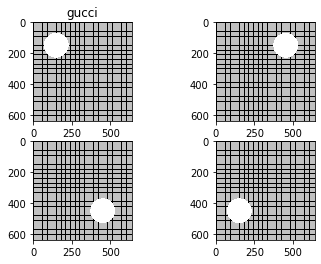

In [72]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(circles[0], cmap='gray')
axarr[0,1].imshow(circles[1], cmap='gray')
axarr[1,0].imshow(circles[2], cmap='gray')
axarr[1,1].imshow(circles[3], cmap='gray')

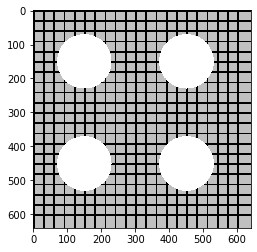

In [12]:
I_max = get_maximum(circles)
plt.imshow(I_max, cmap='gray')

mb sobel

## Calculate intensity gradients $G_k$ gradients of $I_k$. Sobel and numpy

In [18]:
G_sobel_x = []
G_sobel_y = []
G_np_x = []
G_np_y = []
# G = []
for circle in circles:
    
    sobelx = cv2.Sobel(circle,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(circle,cv2.CV_64F,0,1,ksize=5)
    G_sobel_x.append(sobelx)
    G_sobel_y.append(sobely)
    
    print(f"stats X: {stats(sobelx)}")
    print(f"stats Y: {stats(sobely)}")
    
    print("=" * 20)
    
    g_x, g_y = np.gradient(circle)
    G_np_x.append(g_x)
    G_np_y.append(g_y)    
    
    print(f"g_x : {stats(g_x)}")
    print(f"g_y : {stats(g_y)}")
    
    print("-" * 20)
    



stats X: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640), -127.5, 0.0, 127.5)
g_y : (dtype('float64'), (640, 640), -127.5, 0.0, 127.5)
--------------------
stats X: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640), -127.5, 0.0, 127.5)
g_y : (dtype('float64'), (640, 640), -127.5, 0.0, 127.5)
--------------------
stats X: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640), -127.5, 0.0, 127.5)
g_y : (dtype('float64'), (640, 640), -127.5, 0.0, 127.5)
--------------------
stats X: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640), -127.5, 0.0, 127.5)
g_y : (dtype('float64'), (

## $G$ median of gradients ($G(x, y)= median_{k} (G_k(x,y))$). Sobel and numpy

In [19]:
G_sobel_median_x = np.median(G_sobel_x, axis=0)
G_sobel_median_y = np.median(G_sobel_y, axis=0)

G_np_median_x = np.median(G_np_x, axis=0)
G_np_median_y = np.median(G_np_y, axis=0)

In [20]:
print(f"sobel_x median: {stats(G_sobel_median_x)}")
print(f"numpy_x median: {stats(G_np_median_x)}")

sobel_x median: (dtype('float64'), (640, 640), -9216.0, 0.0, 9216.0)
numpy_x median: (dtype('float64'), (640, 640), -96.0, 0.0, 96.0)


## Poisson equation

### divergence of the vector field G

In [21]:
sobelx = cv2.Sobel(G_sobel_median_x,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(G_sobel_median_y,cv2.CV_64F,0,1,ksize=5)
div_G_sobel = sobelx + sobely

x_x, x_y = np.gradient(G_np_median_x)
y_x, y_y = np.gradient(G_np_median_y)
div_G_np = x_x + y_y

In [22]:
print(f"div_G_sobel: {stats(div_G_sobel)}")
print(f"div_G_np: {stats(div_G_np)}")

div_G_sobel: (dtype('float64'), (640, 640), -756864.0, 0.0, 491520.0)
div_G_np: (dtype('float64'), (640, 640), -96.0, 0.0, 48.0)


### Solver

In [23]:
def calc_R(alpha, I, I_max):
    return alpha * I + (1 - alpha) * I_max

In [24]:
def solve_poisson(shape, div_G):
    A = pyamg.gallery.poisson(shape, format='csr')  # 2D Poisson problem on 500x500 grid
    ml = pyamg.ruge_stuben_solver(A)                    # construct the multigrid hierarchy
    print(ml)                                           # print hierarchy information
    b = div_G.ravel()
    x = ml.solve(b, tol=1e-10)
    print("residual: ", np.linalg.norm(b-A*x)) 
    return x

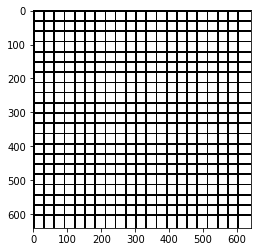

In [28]:
I_median = np.median(circles, axis=0)
plt.imshow(I_median.astype('uint8'), cmap='gray')

#### By color img

In [29]:
shape = (size, size)

#### Sobel

In [48]:
%%time
colors_sobel = cv2.split(div_G_sobel)
ans = solve_poisson(shape, div_G_sobel).reshape(-1, size)

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  0.007012695747917715
Wall time: 1.47 s


In [80]:
print(f"ans: {stats(ans)}")

ans: (dtype('float64'), (640, 640), -3140722.3041833118, -912925.1457602183, 2725807.721718561)


In [88]:
test = np.copy(-1 * ans)
test -= np.min(test)
test /= np.max(test) / 255
test[test > 255] = 255
print(f"test: {stats(test)}")

test: (dtype('float64'), (640, 640), 0.0, 158.16451583991415, 255.0)


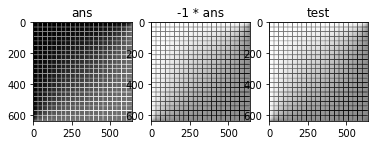

In [90]:
f, ax = plt.subplots(1,3)
ax[0].set_title("ans")
ax[1].set_title("-1 * ans")
ax[2].set_title("test")

ax[0].imshow(ans, cmap='gray')
ax[1].imshow(-1*ans, cmap='gray')
ax[2].imshow(test, cmap='gray')

In [61]:
print(f"I_max : {stats(I_max)}")

I_max : (dtype('uint8'), (640, 640), 0, 192.0, 255)


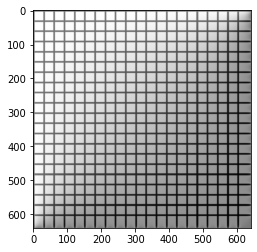

In [70]:
R = calc_R(0.8, -1*ans, I_max)
plt.imshow(R, cmap='gray')

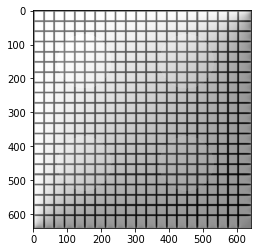

In [100]:
R = calc_R(0.92, test, I_max)
plt.imshow(R, cmap='gray')